In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
datetime.datetime.strptime
from pandas import to_datetime
from collections import defaultdict
from scipy.stats.stats import pearsonr


In [ ]:
# Legge il CSV
df = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0)
# Trasforma il campo "Sale" in un float
df["Sale"] = df["Sale"].str.replace(",", ".").astype(float)
# Trasforma il campo "BasketDate" in un datetime
df["BasketDate"] = pd.to_datetime(df["BasketDate"])

df.head()

# DATA SEMANTICS



In [ ]:
df.info()

Nel dataset si descrivono le sessioni di acquisto di un certo numero di clienti. Una sessione di acquisto, detta basket (`BasketID`) e si svolge in una data (`BasketDate`), e viene effettuata da un cliente (CustomerID) residente in uno stato (`CustomerCountry`).
Ogni sessione rappresenta una serie di prodotti acquistati da un cliente, e in un record è possibile ritrovare, per il singolo prodotto, l’identificativo (`ProdID`), la descrizione (`ProdDescr`), e  la quantità (`Qtà`). Infine viene riportato il costo unitario del prodotto (`Sale`).

# DISTRIBUTION OF VARIABLES AND STATISTICS


In [ ]:
df.describe()

In [ ]:
print("Distinct Values in BasketID: \n", df.BasketID.nunique())
print("Distinct Values in BasketDate:\n", df.BasketDate.nunique())
print("Distinct Values in Sale: \n", df.Sale.nunique())
print("Distinct Values in CustomerID: \n", df.CustomerID.nunique())
print("Distinct Values in CustomerCountry: \n", df.CustomerCountry.nunique())
print("Distinct Values in ProdID: \n", df.ProdID.nunique())
print("Distinct Values in ProdDescr: \n", df.ProdDescr.nunique())

## Date e ore di maggiore traffico nei negozi

## Orari di maggiore frequentazione

Di seguito si mostrano i diagrammi a barre contenenti il numero di `BasketID` per ora del giorno.

In [ ]:
df.groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

L'ora del giorno più frequentata sembra essere le 12.

Si restringono le date al 2010 e si osserva come in questo anno l'ora più frequentata siano le 14

In [ ]:
df[df["BasketDate"].dt.year == 2010].groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

Mentre nel 2011 l'orario di maggiore frequenza si confermano le 12.

In [ ]:
df[df["BasketDate"].dt.year == 2011].groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

## Date di maggiore frequentazione

Si mostrano le date di maggiore traffico per gli anni 2010 e 2011

Dato che relativamente al 2010 sono presenti solo 20 record è possibile mostrarli in un unico grafico

In [ ]:
df_2010 = df[df["BasketDate"].dt.year == 2010]

print(df_2010["BasketDate"].dt.date.nunique())

df_2010.groupby(df["BasketDate"].dt.date)["BasketID"].count().plot(kind="bar")

TODO: Grafici per ogni gruppo di mesi del 2011

In [ ]:
first_three_months = df[(df["BasketDate"].dt.year == 2011) & (df["BasketDate"].dt.month < 3 )]

first_three_months.groupby(df["BasketDate"].dt.date)["BasketID"].count().plot(kind="bar")

## Paesi in cui sono stati effettuati piu acquisti

In [ ]:
df.groupby('CustomerCountry')["BasketID"].nunique().plot(kind='bar',

title='Best buy coutry')

In [ ]:
#verificare a cosa è dovuta la variazione di prezzo
df.groupby(["ProdID",'Qta'])["Sale"].unique()

# ASSESSING DATA QUALITY (MISSING VALUES, OUTLIERS)

In [ ]:
df.info()

Si osserva che le uniche quantità settate a NaN sono `CustomerID` e le `ProdDescr`. I record che non hanno `CustomerID` non portano informazioni riguardo al profilo del cliente, mentre la `ProdDescr` può essere recuperata dai record con lo stesso `ProdID`.

In [ ]:
x = df[(df["ProdDescr"].fillna("").str.islower())]
display(x)
display("Number of BasketIDs", x["BasketID"].nunique())

Tutti i record che hanno `ProdDescr` scritta tutta in minuscolo hanno `CustomerID` a NaN e il loro carrello (`BasketID`) contiene un solo elemento. Si può quindi supporre che non si riferiscano ad una vera e propria transazione con un cliente, e si sceglie di eliminarli dal dataset.

In [ ]:
df = df[~(df["ProdDescr"].fillna("").str.islower())]

## Outliers nella quantità (`Qta`)

La distribuzione della quantità segue la seguente distribuzione:

In [ ]:
boxplot = df.boxplot(column=['Qta'])

Analizziamo meglio i record che si mostrano esterni al box plot:

In [ ]:
df[(df["Qta"] < -60000) | (df["Qta"] > 60000)]

Questi 4 record hanno le stesse caratteristiche e si eliminano a vicenda, per cui non portano informazione e possono essere eliminati.

In [ ]:
df = df[(df["Qta"] > -60000) & (df["Qta"] < 60000)]

In [ ]:
df[(df["Qta"] > -5000) & (df["Qta"] < 5000)].boxplot(column="Qta")

In [ ]:
df[(df["Qta"] < 0)]
#9752 record

In [ ]:
df[(df["Qta"] < 0) & (df["BasketID"].str.startswith("C"))]
#9084 di 9752 hanno BasketId che inizia con C, tutti con CustomerID 
#diverso da Nan ==> vengono mantenuti 

In [ ]:
df[(df["Qta"] < 0) & (df["BasketID"].str.startswith("C")) & (df['CustomerID'].isnull())]
#179 record con CustomerId=Nan ==> rimossi

In [ ]:
df[(df["Qta"] < 0) & (df["BasketID"].str.startswith("C")) & ~(df['CustomerID'].isnull())]
#infatti abbiamo 8905 record con CustomerID != Nan
#8905+179=9084

In [ ]:
df[df["Sale"] > 30000] #manual di valore massimo 
df[(df["ProdDescr"] == 'Manual')]
#se esiste un solo ProdId che ha tale Sale, possiamo fixarlo, altrimenti rimuoviamo/decidere
#potrebbe essere roba inserita a mano

Boxplot raggruppato per paese

In [ ]:
df.boxplot(column=["CustomerID"], by="CustomerCountry")

# Outliers in Sale

In [ ]:
df["Sale"].plot.box()

In [ ]:
df[(df["Sale"] < 0)]
#vengono rimossi

In [ ]:
df=df[(df["Sale"] >= 0)]

In [ ]:
df[df["Sale"] > 30000]
#viene mantenuto in quanto ha informazioni

# VARIABLES TRANSFORMATION & GENERATION

## Prezzo nullo

I record con prezzo 0 si considerano missing values, per cui si cerca di recuperare il valore di `Sale` a partire dalla media dei prezzi dello stesso `ProdID`.

In [ ]:
df["Sale"] = df.groupby("ProdID")["Sale"].transform(lambda group: group.replace(to_replace=0, method="ffill", value = group.mean()))

## ProdDescr non disponibile

Per rendere più interpretabili certe analisi riteniamo che sia utile recuperare la `ProdDescr` degli elementi che non l'hanno settata. Analogamente al caso precedente, si costruisce una funzione che recupera la descrizione di ogni prodotto dagli altri record.

In [ ]:
def replace_first_notna(group: pd.Series, column: str):
    # Indice del primo record con ProdID comune non NaN
    i: int = group.first_valid_index()
    # Se i è None non ci sono ProdDescr valide
    if i is None:
        return group
    # Valore di ProdDescr valido
    value = df.loc[i][column]
    return group.fillna(value)
 
df["ProdDescr"] = df.groupby("ProdID")["ProdDescr"].transform(lambda x: replace_first_notna(x, "ProdDescr"))

In [ ]:
df[df["ProdDescr"].isnull()]

# PAIRWISE CORRELATION & ELIMINATION OF REDUNTANT VARIABLES

Si discretizzano le variabili non numeriche all'interno del dataset:

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_copy = df.copy()
for column in {"BasketID", "BasketDate", "CustomerCountry", "ProdID", "ProdDescr"}:
    df_copy[column] = le.fit_transform(df_copy[column].astype(str))

Si definisce la matrice di correlazione tra gli attributi:

In [ ]:
df_copy.corr().abs().style.background_gradient(cmap='coolwarm')

Dato che non si osservano correlazioni notevoli (maggiori dell'80%) non è il caso di eliminare attributi ridondanti.

In [ ]:
df.to_csv("./preprocessed.csv")

# DATA PREPARATION

Costruzione di attributi che caratterizzano il comportamento di un utente.

Si caricano i dati preprocessati, considerando per ora solo quelli con `CustomerID` non nullo:

In [2]:
df = pd.read_csv("./preprocessed.csv", index_col=0)
df = df[~(df["CustomerID"].isnull())]
df["BasketDate"] = pd.to_datetime(df["BasketDate"])
df

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6
...,...,...,...,...,...,...,...,...
541905,581587,2011-09-12 12:50:00,2.10,12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,6
541906,581587,2011-09-12 12:50:00,4.15,12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4
541907,581587,2011-09-12 12:50:00,4.15,12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4
541908,581587,2011-09-12 12:50:00,4.95,12680.0,France,22138,BAKING SET 9 PIECE RETROSPOT,3


In [3]:
from indicators import customer_features

customer_indicators = df.groupby("CustomerID").apply(customer_features)
customer_indicators = pd.DataFrame(customer_indicators.values.tolist(), index=customer_indicators.index)
customer_indicators

,I,Iu,spending,Imax,returned_items,best_country,returning,most_bought,most_returned,hour,month,baskets,E
CustomerID,,,,,,,,,,,,,
12347.0,182,103,4310.00,676,0,Iceland,0.00,22375,None,14,7,7,6.015601
12348.0,31,22,1797.24,1254,0,Finland,0.00,POST,None,19,12,4,4.233442
12349.0,73,73,1757.55,631,0,Italy,0.00,20685,None,9,11,1,5.802215
12350.0,17,17,334.40,197,0,Norway,0.00,20615,None,16,2,1,3.977269
12352.0,95,59,2506.04,127,66,Norway,-960.63,POST,M,14,3,11,5.567352
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,10,10,180.60,45,0,United Kingdom,0.00,22084,None,9,7,1,3.207542
18281.0,7,7,80.82,54,0,United Kingdom,0.00,22028,None,10,12,1,2.462523
18282.0,13,12,178.05,75,5,United Kingdom,-1.45,21108,23187,13,5,3,2.660805


## Hierarchical clustering

Si sperimentano varie invocazioni dell'oggetto `AgglomerativeClustering` e come i clusters generati cambiano al variare delle metriche adottate.

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

X = scaler.fit_transform(customer_indicators[["I", "Iu", "spending", "Imax", "returned_items", "returning", "baskets", "E", "hour", "month"]].values)

X

array([[ 0.38253107,  0.48905563,  0.2724529 , ...,  0.93361624,
         0.65463635,  0.04296654],
       [-0.26702164, -0.45919538, -0.0220489 , ..., -0.11600832,
         2.81876845,  1.52643211],
       [-0.08635135,  0.13785155, -0.02670066, ...,  0.80793987,
        -1.50949576,  1.22973899],
       ...,
       [-0.34445176, -0.57626341, -0.21182204, ..., -1.04223262,
         0.22180993, -0.55041969],
       [ 2.85169168,  2.36214405,  0.01283526, ...,  1.67911004,
         0.65463635, -0.25372657],
       [-0.09925637, -0.02604369, -0.01735611, ...,  0.60060061,
        -1.07666934,  1.52643211]])

In [5]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=5, linkage="ward")
complete = AgglomerativeClustering(n_clusters=5, linkage="complete")
average = AgglomerativeClustering(n_clusters=5, linkage="average")
single = AgglomerativeClustering(n_clusters=5, linkage="single")

ward.fit_predict(X)
complete.fit_predict(X)
average.fit_predict(X)
single.fit_predict(X)

array([0, 0, 0, ..., 0, 0, 0])

In [6]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

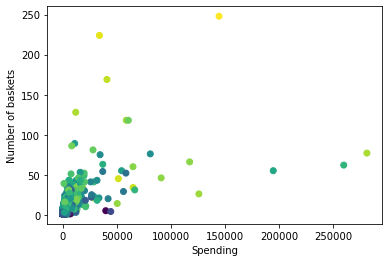

In [7]:
plt.xlabel("Spending")
plt.ylabel("Number of baskets")
plt.scatter(
    x = customer_indicators["spending"],
    y = customer_indicators["baskets"],
    c = customer_indicators["E"]
)

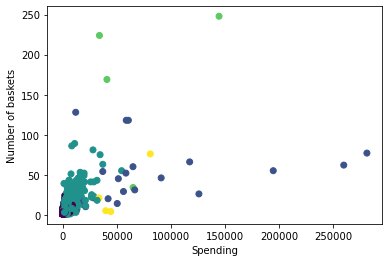

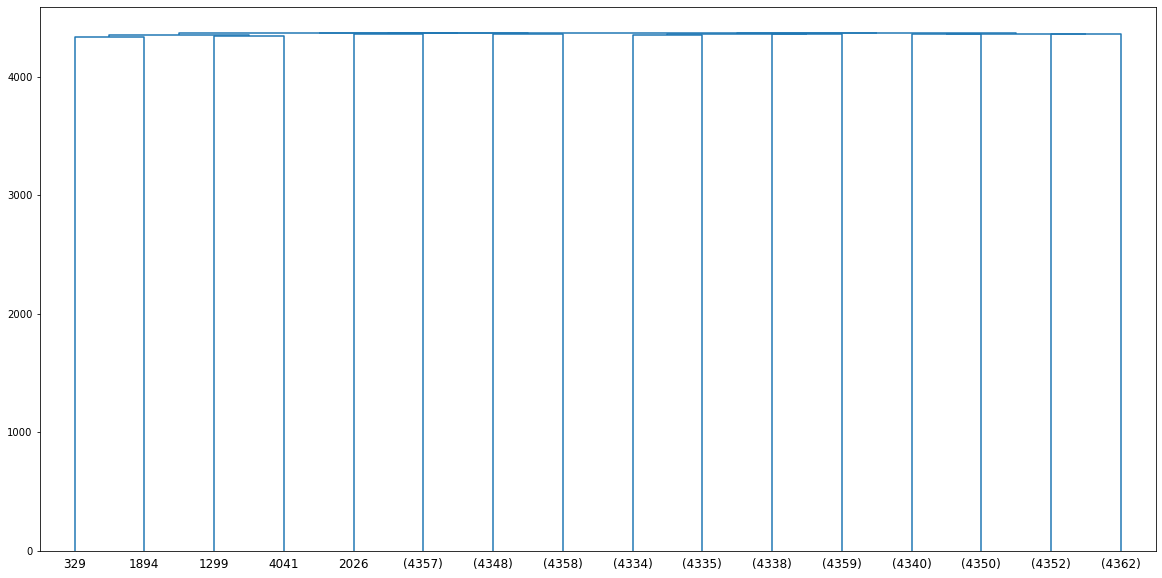

In [10]:
# Ward
plt.xlabel("Spending")
plt.ylabel("Number of baskets")
plt.scatter(
    x = customer_indicators["spending"],
    y = customer_indicators["baskets"],
    c = ward.labels_
)
plt.figure(figsize=(20, 10))
plot_dendrogram(ward, truncate_mode='level', p=3)

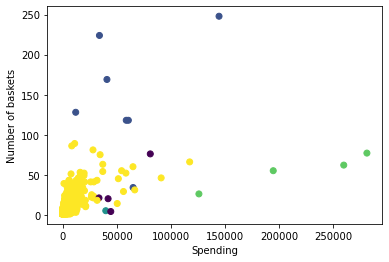

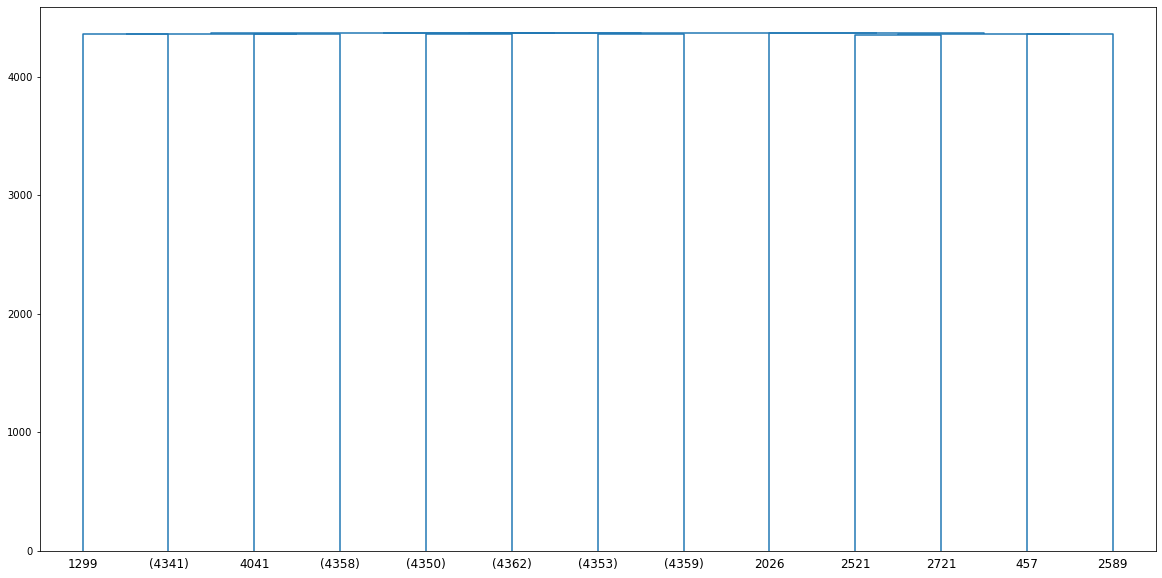

In [11]:
# Complete
plt.xlabel("Spending")
plt.ylabel("Number of baskets")
plt.scatter(
    x = customer_indicators["spending"],
    y = customer_indicators["baskets"],
    c = complete.labels_
)
plt.figure(figsize=(20, 10))
plot_dendrogram(complete, truncate_mode='level', p=3)

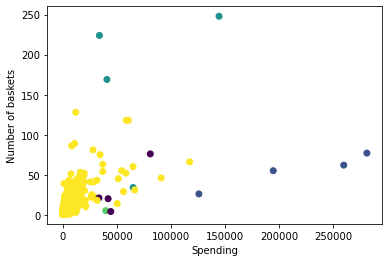

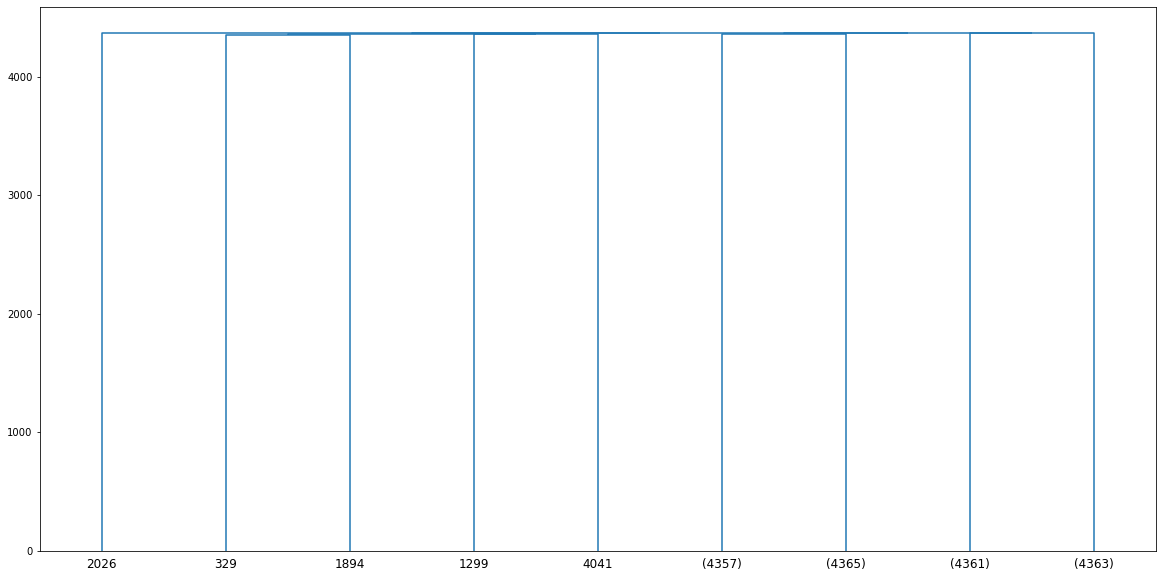

In [13]:
# Average
plt.xlabel("Spending")
plt.ylabel("Number of baskets")
plt.scatter(
    x = customer_indicators["spending"],
    y = customer_indicators["baskets"],
    c = average.labels_
)
plt.figure(figsize=(20, 10))
plot_dendrogram(average, truncate_mode='level', p=3)

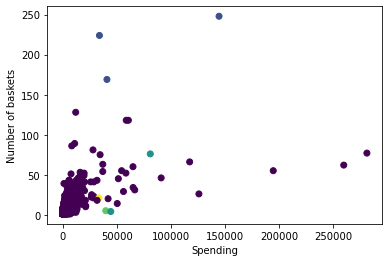

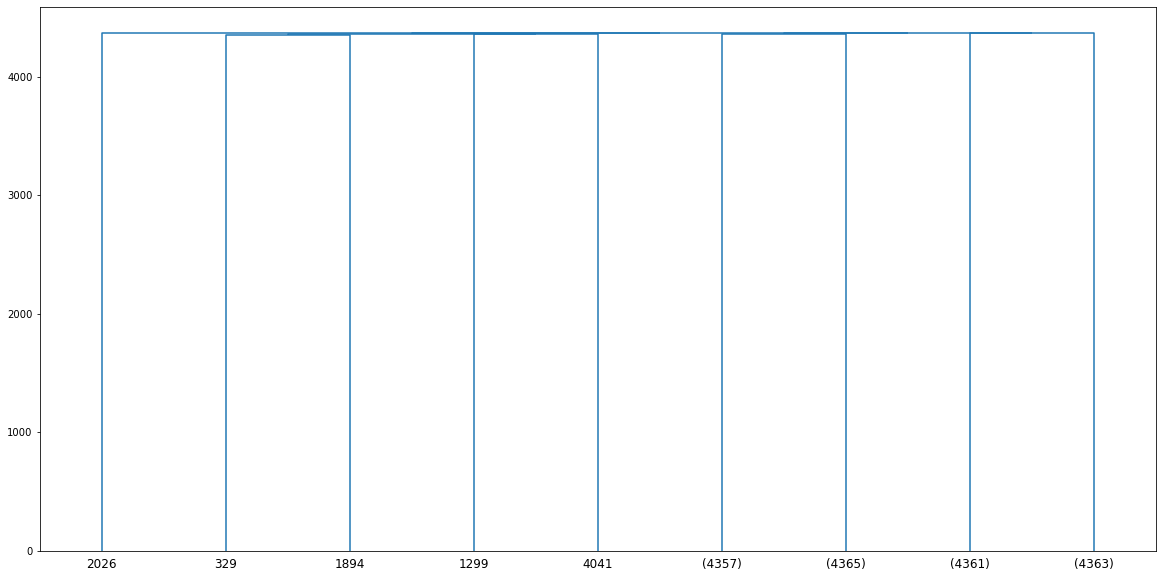

In [14]:
# Single
plt.xlabel("Spending")
plt.ylabel("Number of baskets")
plt.scatter(
    x = customer_indicators["spending"],
    y = customer_indicators["baskets"],
    c = single.labels_
)
plt.figure(figsize=(20, 10))
plot_dendrogram(average, truncate_mode='level', p=3)

## Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
Y = pca.fit_transform(X)
plt.scatter(x = Y[:, 0], y = Y[:, 1], c=Y[:, 2])

In [ ]:
customer_indicators.sort_values(by=["hour", "month"])